#  Basic demonstration of pyMCR

pyMCR is a small package for performing multivariate curve resolution. Currently, it implements a simple alternating regression (MCR-AR) scheme. When the regressors are ordinary least-squares, this is MCR-alternating least-squares (MCR-ALS).

When using nonnegativity constraints, MCR is the same as nonnegative matrix factorization (NMF). Historically, other names were used for MCR as well:
- Self modeling mixture analysis (SMMA)
- Self modeling curve resolution (SMCR)

Available methods:
- Regressors:
    - Ordinary least squares (default)
    - Non-negatively constrained least squares
    - Native support for scikit-learn linear model regressors (e.g., LinearRegression, RidgeRegression, Lasso)
- Constraints
    -   Non-negativity
    -   Normalization
    -   Zero end-points
    -   Zero (approx) end-points of cumulative summation (can specify nodes as well)
    -   Non-negativity of cumulative summation
    -   Compress or cut values above or below a threshold value
    -   Replace sum-across-features samples (e.g., 0 concentration) with prescribed target
    -   Enforce a plane ("planarize"). E.g., a concentration image is a plane.

**MCR assumes a system of the form: D = CS^T**
    
Data that you will provide (hyperspectral context):
    
`D [n_pixels, n_frequencies]  # Hyperspectral image unraveled in space (2D)`
    
`initial_spectra [n_components, n_frequencies]  ## S^T in the literature`
    
OR

`initial_conc [n_pixels, n_components]   ## C in the literature`

If you have an initial estimate of the spectra

`mcrar.fit(D, ST=initial_spectra)`

Otherwise, if you have an initial estimate of the concentrations

`mcrar.fit(D, C=initial_conc)`

In [1]:
import sys

import numpy as np
import logging

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100

# importing pymcr pieces
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

from sklearn.linear_model.ridge import Ridge

# Set logger to print to stdout

* PyMCR uses Python's logging library for messaging (instead of print statements)
* Logging module: https://docs.python.org/3.7/library/logging.html
* Logging tutorial: https://docs.python.org/3.7/howto/logging.html#logging-basic-tutorial
* Logging cookbook: https://docs.python.org/3.7/howto/logging-cookbook.html#logging-cookbook

In [2]:
logger = logging.getLogger('pymcr')

logger.setLevel(logging.DEBUG)

# StdOut is a "stream"; thus, StreamHandler
stdout_handler = logging.StreamHandler(stream=sys.stdout)

# Set the message format. Simple and removing log level or date info
stdout_format = logging.Formatter('%(message)s')  # Just a basic message akin to print statements
stdout_handler.setFormatter(stdout_format)

logger.addHandler(stdout_handler)

# Define model system

## Initial spectal components

Text(0.5, 1.0, 'Spectral Components')

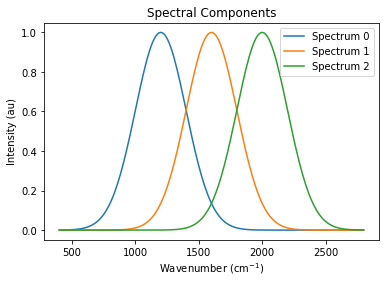

In [3]:
wn = np.linspace(400,2800,200)

n_components = 3

sp0 = np.exp(-(wn-1200)**2/(2*200**2))
sp1 = np.exp(-(wn-1600)**2/(2*200**2))
sp2 = np.exp(-(wn-2000)**2/(2*200**2))

plt.plot(wn, sp0, label='Spectrum 0')
plt.plot(wn, sp1, label='Spectrum 1')
plt.plot(wn, sp2, label='Spectrum 2')
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.legend(loc='best')
plt.title('Spectral Components')


## Concentration map

Model starts off as 3 2D-Gaussian centered at (x*, y*) with standard deviation R (1 for each component).

The sum to 1 constraint is then enforced.

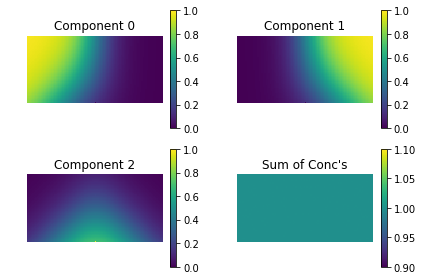

In [4]:
x0 = 25
y0 = 25

x1 = 75
y1 = 25

x2 = 50
y2 = 50

R = 20

M=50  # rows (Y)
N= 100  # cols (X)

# Init concentration map
conc = np.zeros((M,N,n_components))

X,Y = np.meshgrid(np.arange(N), np.arange(M))

conc[...,0] = np.exp(-(X-x0)**2/(2*R**2))*np.exp(-(Y-y0)**2/(2*R**2))
conc[...,1] = np.exp(-(X-x1)**2/(2*R**2))*np.exp(-(Y-y1)**2/(2*R**2))
conc[...,2] = np.exp(-(X-x2)**2/(2*R**2))*np.exp(-(Y-y2)**2/(2*R**2))

conc /= conc.sum(axis=-1)[:,:,None]

# Find the maximum concentration (per component)
# and set to conc = 1 (and make the rest 0's)
# This just ensures that each component has a pure
# pixel somewhere within the image
for num in range(n_components):
    idx = np.unravel_index(conc[...,num].argmax(), conc[...,num].shape)
    tmp = np.zeros(3)
    tmp[num] = 1
    conc[idx[0],idx[1],:] = 1*tmp

plt.figure(figsize=(6,4))
for num in range(3):
    plt.subplot(2,2,num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    plt.title('Component {}'.format(num))

plt.subplot(2,2,4)
plt.imshow(conc.sum(axis=-1))
plt.colorbar()
plt.axis('off')
plt.title('Sum of Conc\'s')
plt.tight_layout()

In [5]:
# Stack 3 spectral vectors into 1 matrix
spectra = np.vstack((sp0, sp1, sp2))

# Hyperspectral image (HSI)
hsi = np.dot(conc, spectra)

# Perform MCR-AR

## With spectral guess

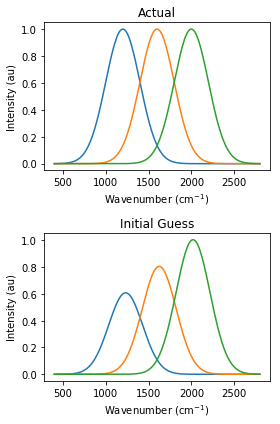

In [6]:
# Poor guess
initial_spectra = spectra*wn/2000

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(212)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.tight_layout()

# Preparing PyMCR fit

## Manual ordering and selection of constraints

Constrains are imported from pymcr.constraints

- ConstraintNonneg is a non-negativity constraint. All negative entries made 0.

- ConstraintNorm is  a normalization constraint, i.e. everything sums to unity.

## Regressor selection

Different regressor can be selected for calculating the C matrix (c_reg) or the S^T matrix (st_regr).

In the following, we initiate a McrAR object with a st_regr setup with NNLS and c_reg to OLS. One can select regressor with a string, or can import the class and instanstiate.

In [7]:
mcrar = McrAR(max_iter=100, st_regr='NNLS', c_regr=OLS(), 
                c_constraints=[ConstraintNonneg(), ConstraintNorm()])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 8.8447e-03
Iter: 1 (ST)	mse: 3.2199e-04
Iter: 2 (C)	mse: 1.5935e-04
Iter: 2 (ST)	mse: 9.4332e-05
Iter: 3 (C)	mse: 6.4088e-05
Iter: 3 (ST)	mse: 4.4970e-05
Iter: 4 (C)	mse: 3.4988e-05
Iter: 4 (ST)	mse: 2.7080e-05
Iter: 5 (C)	mse: 2.2584e-05
Iter: 5 (ST)	mse: 1.8471e-05
Iter: 6 (C)	mse: 1.5972e-05
Iter: 6 (ST)	mse: 1.3516e-05
Iter: 7 (C)	mse: 1.1947e-05
Iter: 7 (ST)	mse: 1.0344e-05
Iter: 8 (C)	mse: 9.2744e-06
Iter: 8 (ST)	mse: 8.1643e-06
Iter: 9 (C)	mse: 7.3999e-06
Iter: 9 (ST)	mse: 6.5963e-06
Iter: 10 (C)	mse: 6.0289e-06
Iter: 10 (ST)	mse: 5.4282e-06
Iter: 11 (C)	mse: 4.9948e-06
Iter: 11 (ST)	mse: 4.5337e-06
Iter: 12 (C)	mse: 4.1975e-06
Iter: 12 (ST)	mse: 3.8356e-06
Iter: 13 (C)	mse: 3.5684e-06
Iter: 13 (ST)	mse: 3.2790e-06
Iter: 14 (C)	mse: 3.0648e-06
Iter: 14 (ST)	mse: 2.8308e-06
Iter: 15 (C)	mse: 2.6570e-06
Iter: 15 (ST)	mse: 2.4640e-06
Iter: 16 (C)	mse: 2.3209e-06
Iter: 16 (ST)	mse: 2.1604e-06
Iter: 17 (C)	mse: 2.0422e-06
Iter: 17 (ST)	mse: 1.9080e-06
Iter: 18 (C)	ms

# Plotting the results

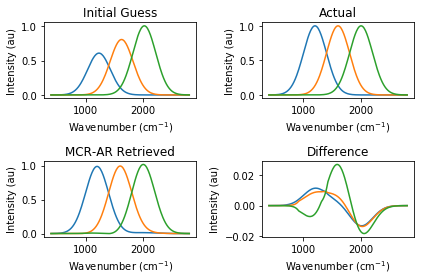

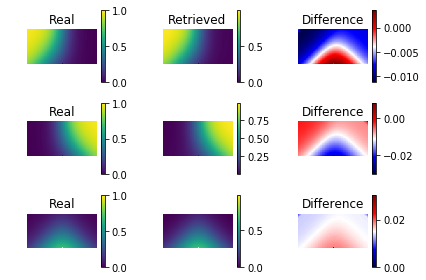

In [8]:
plt.figure(figsize=(6,4))
plt.subplot(221)
plt.plot(wn, initial_spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Initial Guess')

plt.subplot(222)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(223)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(224)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.savefig('mcr_spectra_retr.png')
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    
    plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    plt.title('Difference')

plt.tight_layout()
plt.savefig('mcr_conc_retr.png')
plt.show()

## With concentration guess and Alternating NNLS Regressions

We initiate a poor guess of concentrations to be used by AlsMcr

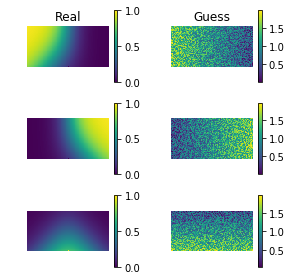

In [9]:
# Poor guess
initial_conc = np.zeros((M,N,3))
initial_conc[...,0] = np.dot(np.ones(M)[:,None], (np.arange(N,0,-1)/N)[None,:])
initial_conc[...,1] = np.dot(np.ones(M)[:,None], (np.arange(N)/N)[None,:])
initial_conc[...,2] = np.dot((np.arange(M)/M)[:,None], np.ones(N)[None,:])
initial_conc += np.random.rand(M,N,3)

plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(initial_conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Guess')
plt.tight_layout()
    


## Performing the fit

c_regre and st_regr are setup to NNLS, constrains are activated.

In [10]:
mcrar = McrAR(max_iter=200, tol_increase=2,c_regr='NNLS',
                st_regr='NNLS', c_constraints=[ConstraintNorm()])

mcrar.fit(hsi.reshape((-1, wn.size)), C=initial_conc.reshape((M*N,n_components)),
           verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (ST)	mse: 1.7523e-02
Iter: 2 (C)	mse: 4.5428e-02
Iter: 2 (ST)	mse: 1.0118e-03
Iter: 3 (C)	mse: 4.2613e-04
Iter: 3 (ST)	mse: 1.6753e-04
Iter: 4 (C)	mse: 1.2534e-04
Iter: 4 (ST)	mse: 6.7795e-05
Iter: 5 (C)	mse: 5.7304e-05
Iter: 5 (ST)	mse: 3.6863e-05
Iter: 6 (C)	mse: 3.2891e-05
Iter: 6 (ST)	mse: 2.3725e-05
Iter: 7 (C)	mse: 2.1799e-05
Iter: 7 (ST)	mse: 1.6998e-05
Iter: 8 (C)	mse: 1.5894e-05
Iter: 8 (ST)	mse: 1.3097e-05
Iter: 9 (C)	mse: 1.2394e-05
Iter: 9 (ST)	mse: 1.0628e-05
Iter: 10 (C)	mse: 1.0147e-05
Iter: 10 (ST)	mse: 8.9692e-06
Iter: 11 (C)	mse: 8.6209e-06
Iter: 11 (ST)	mse: 7.7915e-06
Iter: 12 (C)	mse: 7.5282e-06
Iter: 12 (ST)	mse: 6.9214e-06
Iter: 13 (C)	mse: 6.7141e-06
Iter: 13 (ST)	mse: 6.2546e-06
Iter: 14 (C)	mse: 6.0851e-06
Iter: 14 (ST)	mse: 5.7224e-06
Iter: 15 (C)	mse: 5.5795e-06
Iter: 15 (ST)	mse: 5.2872e-06
Iter: 16 (C)	mse: 5.1639e-06
Iter: 16 (ST)	mse: 4.9224e-06
Iter: 17 (C)	mse: 4.8136e-06
Iter: 17 (ST)	mse: 4.6095e-06
Iter: 18 (C)	mse: 4.5123e-06
Iter: 18 (ST)	

# Plotting the results

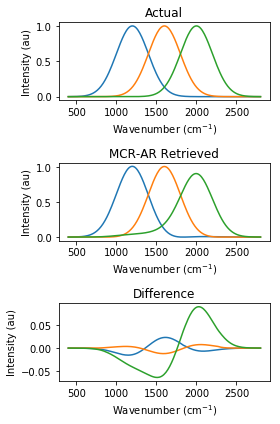

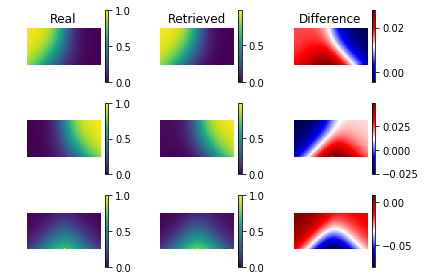

In [11]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()

# Using external regressors

## Scikit-Learn Ridge Regression

It is possible to use an external regressor from scikit learn to perform the fit, instead of using the provided OLS or NNLS algoritm.

The regressor should be initialised and provided to the c_regr and st_regr functions.

In [12]:
mcrar = McrAR(max_iter=100, tol_increase=2, tol_err_change=1e-10,
                c_regr=Ridge(alpha=1), st_regr=NNLS(), 
                c_constraints=[ConstraintNonneg(), ConstraintNorm()])

mcrar.fit(hsi.reshape((-1, wn.size)), ST=initial_spectra, verbose=True)
print('\nFinal MSE: {:.7e}'.format(mcrar.err[-1]))


Iter: 1 (C)	mse: 8.4764e-03
Iter: 1 (ST)	mse: 1.8582e-04
Iter: 2 (C)	mse: 1.4013e-04
Iter: 2 (ST)	mse: 1.0080e-04
Iter: 3 (C)	mse: 8.9624e-05
Iter: 3 (ST)	mse: 7.5907e-05
Iter: 4 (C)	mse: 7.0209e-05
Iter: 4 (ST)	mse: 6.2503e-05
Iter: 5 (C)	mse: 6.1113e-05
Iter: 5 (ST)	mse: 5.5414e-05
Iter: 6 (C)	mse: 5.5539e-05
Iter: 6 (ST)	mse: 5.0914e-05
Iter: 7 (C)	mse: 5.1325e-05
Iter: 7 (ST)	mse: 4.7430e-05
Iter: 8 (C)	mse: 4.8022e-05
Iter: 8 (ST)	mse: 4.4667e-05
Iter: 9 (C)	mse: 4.5361e-05
Iter: 9 (ST)	mse: 4.2416e-05
Iter: 10 (C)	mse: 4.3161e-05
Iter: 10 (ST)	mse: 4.0547e-05
Iter: 11 (C)	mse: 4.1303e-05
Iter: 11 (ST)	mse: 3.8960e-05
Iter: 12 (C)	mse: 3.9690e-05
Iter: 12 (ST)	mse: 3.7578e-05
Iter: 13 (C)	mse: 3.8251e-05
Iter: 13 (ST)	mse: 3.6342e-05
Iter: 14 (C)	mse: 3.6962e-05
Iter: 14 (ST)	mse: 3.5227e-05
Iter: 15 (C)	mse: 3.5796e-05
Iter: 15 (ST)	mse: 3.4217e-05
Iter: 16 (C)	mse: 3.4745e-05
Iter: 16 (ST)	mse: 3.3303e-05
Iter: 17 (C)	mse: 3.3787e-05
Iter: 17 (ST)	mse: 3.2465e-05
Iter: 18 (C)	ms

# Plotting the results with sklearn regressor

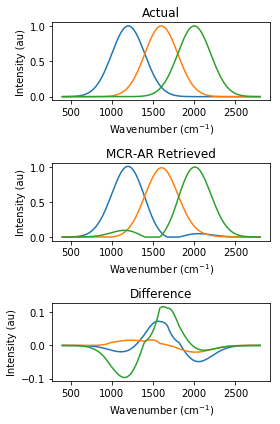

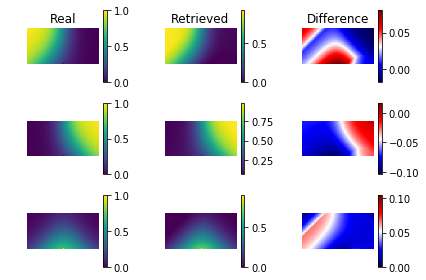

In [13]:
plt.figure(figsize=(4,6))
plt.subplot(311)
plt.plot(wn, spectra.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Actual')

plt.subplot(312)
plt.plot(wn, mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('MCR-AR Retrieved')

plt.subplot(313)
plt.plot(wn, spectra.T - mcrar.ST_opt_.T)
plt.xlabel(r'Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity (au)')
plt.title('Difference')

plt.tight_layout()
plt.show()

temp = mcrar.C_opt_.reshape(conc.shape)
plt.figure(figsize=(6,4))
for num in range(n_components):
    plt.subplot(3,3,3*num+1)
    plt.imshow(conc[...,num])
    plt.colorbar()
    plt.axis('off')
    if num == 0:
        plt.title('Real')

    plt.subplot(3,3,3*num+2)
    plt.imshow(temp[...,num])
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Retrieved')

    plt.subplot(3,3,3*num+3)
    plt.imshow(conc[...,num] - temp[...,num], cmap='seismic')
    plt.colorbar()
    plt.axis('off')

    if num == 0:
        plt.title('Difference')

plt.tight_layout()
plt.show()